# **SST Pipeline which allows for the retrieval of buoy,satellite , and logger data from **

### Running some library, adds relevant packages that we will use below

In [ ]:

# load some library
import xarray as xr
import numpy as np
from shapely.geometry import Point, Polygon
from ndbc_api import NdbcApi
from dateutil.parser import parse
from datetime import datetime, timedelta
import numpy.ma as ma
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import pandas as pd
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from matplotlib.dates import DateFormatter
from sklearn.cluster import KMeans
import folium
import copy

## Set the time range! You can adjust the time range!

* array datasets like the following time format, yyyy-mm-ddT00:00:00
---

In [6]:
start_time = '2019-01-01T12:00:00'
end_time = '2024-12-01T12:00:00'

## If using buoy data set station ID

In [8]:
nsStationID='46244' # Humboldt Bay, North Spit
frStationID='46026' #farallones

formatted_start_time = datetime.strptime(start_time, '%Y-%m-%dT%H:%M:%S').strftime("%Y-%m-%d")
formatted_end_time = datetime.strptime(end_time, '%Y-%m-%dT%H:%M:%S').strftime("%Y-%m-%d")

print(formatted_start_time)
print(formatted_end_time)

2019-01-01
2024-12-01


## Import buoy data

In [ ]:
api = NdbcApi() 
tddata = api.get_data(station_id=nsStationID, start_time=formatted_start_time,mode='stdmet', end_time=formatted_end_time) 
tddata=tddata.reset_index()
hmbdata = api.get_data(station_id=frStationID, start_time=formatted_start_time,mode='stdmet', end_time=formatted_end_time) 
hmbdata=hmbdata.reset_index()
print(tddata)

In [ ]:
print('Humboldt SST')
print(hmbdata['WTMP'])

print('North Spit SST')
print(tddata['WTMP'])

In [ ]:
tddata['timestamp'] = pd.to_datetime(tddata['timestamp'])
tddata['date'] = tddata['timestamp'].dt.date
daily_td_sst=tddata.groupby('date')['WTMP'].mean().reset_index()

In [ ]:
hmbdata['timestamp']=pd.to_datetime(hmbdata['timestamp'])
hmbdata['date'] = hmbdata['timestamp'].dt.date
daily_hmb_sst=hmbdata.groupby('date')['WTMP'].mean().reset_index()

## If you dont know what station id you want use this to find it
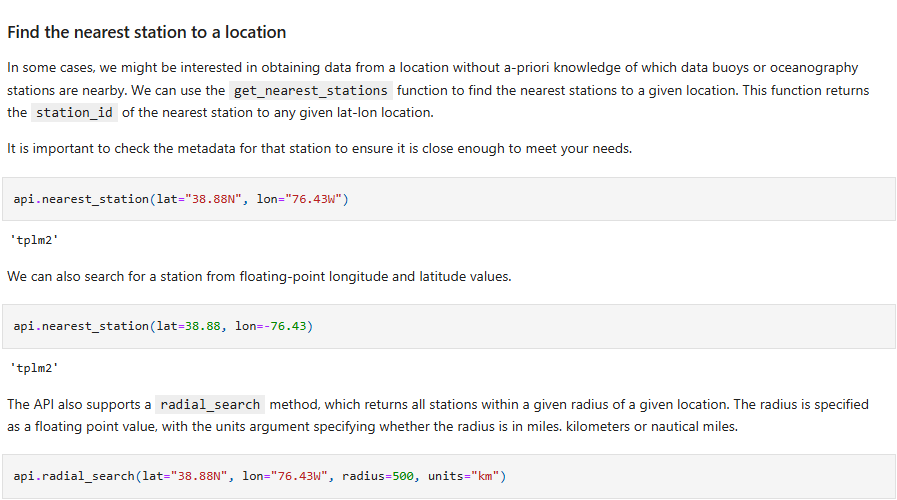

In [ ]:
#info about how to use ndbc ai
#https://github.com/CDJellen/ndbc-api/blob/main/notebooks/overview.ipynb
api.nearest_station(lat="38.88N", lon="76.43W")

In [ ]:
api.station(station_id=frStationID)

## NOAA url





In [ ]:
mur_sst_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41'


## SST satellite data

In [ ]:
sst = xr.open_dataset(mur_sst_url)

## Defining site boundaries

In [ ]:
## format is min_lat, max_lat, min_lon, max_lon
ppn_sst_coordinates=[37.18,37.19,-122.41,-122.40]

pps_sst_coordinates=[37.17,37.18,-122.39,-122.38]

psp_sst_coordinates=[37.19,37.20,-122.42,-122.41]

plp_sst_coordinates=[41.13,41.14,-124.18,-124.17]

lat_min=min(ppn_sst_coordinates[0],pps_sst_coordinates[0],psp_sst_coordinates[0],plp_sst_coordinates[0])
lat_max=max(ppn_sst_coordinates[1],pps_sst_coordinates[1],psp_sst_coordinates[1],plp_sst_coordinates[1])

lon_min=min(ppn_sst_coordinates[2],pps_sst_coordinates[2],psp_sst_coordinates[2],plp_sst_coordinates[2])
lon_max=max(ppn_sst_coordinates[3],pps_sst_coordinates[3],psp_sst_coordinates[3],plp_sst_coordinates[3])


# So now lets map out our field sites

### Subset the dataset to get the lat and lon region and the time period of interest

* we are using the min and max values from the dictionary to get the whole region for all of the sites

* look at the data variables in the array from the cell above to select the
data you're interested in, in this case its analysed sst as found in the data variables from the metadata

---

In [ ]:
our_sst = sst['analysed_sst'].sel(
                      latitude=slice(lat_min, lat_max),
                      longitude=slice(lon_min, lon_max),
                      time=slice(start_time, end_time)
                      )

## Viewing the data array to see what our filtered data looks like

*   if working properly it will return the number of days specified in your entered time ranges

---

In [ ]:
our_sst

<xarray.DataArray 'upwelling' (time: 1985, altitude: 1, latitude: 16,
                               longitude: 7)> Size: 889kB
[222320 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 16kB 2019-01-09 2019-01-10 ... 2024-12-01
  * altitude   (altitude) float64 8B 0.0
  * latitude   (latitude) float64 128B 37.25 37.5 37.75 38.0 ... 40.5 40.75 41.0
  * longitude  (longitude) float64 56B -124.0 -123.8 -123.5 ... -122.8 -122.5
Attributes:
    colorBarMaximum:  2e-05
    colorBarMinimum:  -2e-05
    coordsys:         geographic
    ioos_category:    Currents
    long_name:        Ekman Upwelling
    units:            m s-1

# So now we can map and plot sst with specific sites only.

*   first we need to adjust the coordinates a bit so they go a few km off the coast, results would be skewed or unavailable if land is in the coordinates
*   we'll also make a sample area for each site that is roughly 5x5km
*   the same adjustment appears to work for each site, so below is a function that will make these sample areas for each site



---

In [ ]:
def custom_site_sample_areas_sst(min_lat, max_lat, min_lon, max_lon,site_name):
    '''
    This function creates a sample area for the site using the coordinates
    of all four corners (NW, NE, SE, SW) and extracts data points within the
    bounding box formed by these coordinates.
    '''

    print('Site:', site_name)
    print('lon:', min_lon, max_lon) #uncomment if you want to see the coordinates per your site
    print('lat:', min_lat, max_lat)
    # Open your dataset (assuming it's a NetCDF or similar geospatial file)
    your_sst = sst['analysed_sst']
    your_upwell = upwell['upwelling']
    
    # Efficiently subset the data
    sst_subset = your_sst.sel(
      latitude=slice(min_lat, max_lat), 
      longitude=slice(min_lon, max_lon),
      time=slice(start_time, end_time))
    upwell_subset = your_upwell.sel(
      latitude=slice(min_lat, max_lat), 
      longitude=slice(min_lon, max_lon),
      time=slice(start_time, end_time))
    #1 is a placeholder for the upwelling data didnt feel like reworking the code
    return sst_subset, 1



# Creating Sites

In [ ]:
ppn_sst_beach = custom_site_sample_areas_sst(ppn_sst_coordinates[0],ppn_sst_coordinates[1],ppn_sst_coordinates[2],ppn_sst_coordinates[3],"Pigeon Point North")
pps_sst_beach = custom_site_sample_areas_sst(pps_sst_coordinates[0],pps_sst_coordinates[1],pps_sst_coordinates[2],pps_sst_coordinates[3],"Pigeon Point South")
psp_sst_beach = custom_site_sample_areas_sst(psp_sst_coordinates[0],psp_sst_coordinates[1],psp_sst_coordinates[2],psp_sst_coordinates[3],"Pistachio Point")
plp_sst_beach = custom_site_sample_areas_sst(plp_sst_coordinates[0],plp_sst_coordinates[1],plp_sst_coordinates[2],plp_sst_coordinates[3],"Palmer's Point")


Site: Aramai Point
lon: -122.580725 -122.54072500000001
lat: 37.527919000000004 37.567919
Site: Mussel Beach
lon: -122.57615 -122.53615
lat: 37.5863 37.6263
Site: Slide Ranch
lon: -122.67838 -122.63838000000001
lat: 37.79224 37.83224
Site: Mile Rock
lon: -122.58954 -122.54954000000001
lat: 37.70557 37.74557
Site: Pigeon Point
lon: -122.476642 -122.436642
lat: 37.105969 37.145969
Site: Pigeon Point North
lon: -122.41 -122.4
lat: 37.18 37.19
Site: Pigeon Point South
lon: -122.39 -122.38
lat: 37.17 37.18
Site: Pigeon Point South 2
lon: -122.39 -122.38
lat: 37.16 37.17
Site: Pigeon Point South 3
lon: -122.38 -122.37
lat: 37.16 37.17
Site: Pigeon Point North 3
lon: -122.42 -122.41
lat: 37.19 37.2
Site: Pigeon Point North 2
lon: -122.42 -122.41
lat: 37.18 37.19
Site: Pigeon Point 1
lon: -122.4 -122.39
lat: 37.16 37.17
Site: Pigeon Point 2
lon: -122.42 -122.41
lat: 37.16 37.17
Site: Pigeon Point 3
lon: -122.42 -122.41
lat: 37.17 37.18
Site: Pigeon Point 4
lon: -122.41 -122.4
lat: 37.17 37.18


## Function for visualizing site boundaries on google maps

In [ ]:
# URL of the custom tile layer
tile_url = 'https://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}'



def visualize_boundary(site):
    # Add a marker to the map
    
    marker1 = [max(site[0].latitude), max(site[0].longitude)]  # top right corner
    marker2 = [min(site[0].latitude), min(site[0].longitude)] # bottom left corner
    marker3 = [max(site[0].latitude), min(site[0].longitude)] # top left corner
    marker4 = [min(site[0].latitude), max(site[0].longitude)] # bottom right corner

    # Create a map object centered on a specific location
    map_center = [marker1[0], marker1[1]]  # New York City coordinates
    my_map = folium.Map(location=map_center, zoom_start=12)


    folium.Marker(marker1, popup="Top Right").add_to(my_map)
    folium.Marker(marker2, popup="Bottom Left").add_to(my_map)
    folium.Marker(marker3, popup="Top Left").add_to(my_map)
    folium.Marker(marker4, popup="Bottom Right").add_to(my_map)
    # Add the Esri National Geographic World Map tile layer
    folium.TileLayer(
    tiles=tile_url,
    attr='Tiles &copy; Esri &mdash; National Geographic, Esri, DeLorme, NAVTEQ, UNEP-WCMC, USGS, NASA, ESA, METI, NRCAN, GEBCO, NOAA, iPC',
    max_zoom=16
).add_to(my_map)
    return my_map

def visualize_multiple_boundaries(site1,site2,site3,site4):
    # Add a marker to the map
    marker1 = [max(site1[0].latitude), max(site1[0].longitude)]  # top right corner
    marker2 = [min(site1[0].latitude), min(site1[0].longitude)] # bottom left corner
    marker3 = [max(site1[0].latitude), min(site1[0].longitude)] # top left corner
    marker4 = [min(site1[0].latitude), max(site1[0].longitude)] # bottom right corner

    marker5 = [max(site2[0].latitude), max(site2[0].longitude)]  # top right corner
    marker6 = [min(site2[0].latitude), min(site2[0].longitude)] # bottom left corner
    marker7 = [max(site2[0].latitude), min(site2[0].longitude)] # top left corner
    marker8 = [min(site2[0].latitude), max(site2[0].longitude)] # bottom right corner
    
    marker9 = [max(site3[0].latitude), max(site3[0].longitude)]  # top right corner
    marker10 = [min(site3[0].latitude), min(site3[0].longitude)] # bottom left corner
    marker11 = [max(site3[0].latitude), min(site3[0].longitude)] # top left corner
    marker12 = [min(site3[0].latitude), max(site3[0].longitude)] # bottom right corner
    
    marker13 = [max(site4[0].latitude), max(site4[0].longitude)]  # top right corner
    marker14 = [min(site4[0].latitude), min(site4[0].longitude)] # bottom left corner
    marker15 = [max(site4[0].latitude), min(site4[0].longitude)] # top left corner
    marker16 = [min(site4[0].latitude), max(site4[0].longitude)] # bottom right corner

    # Create a map object centered on a specific location
    map_center = [marker1[0], marker1[1]]  # New York City coordinates
    my_map = folium.Map(location=map_center, zoom_start=12)


    folium.Marker(marker1, popup="Top Right").add_to(my_map)
    folium.Marker(marker2, popup="Bottom Left").add_to(my_map)
    folium.Marker(marker3, popup="Top Left").add_to(my_map)
    folium.Marker(marker4, popup="Bottom Right").add_to(my_map)
    
    folium.Marker(marker5, popup="Top Right").add_to(my_map)
    folium.Marker(marker6, popup="Bottom Left").add_to(my_map)
    folium.Marker(marker7, popup="Top Left").add_to(my_map)
    folium.Marker(marker8, popup="Bottom Right").add_to(my_map)
    
    folium.Marker(marker9, popup="Top Right").add_to(my_map)
    folium.Marker(marker10, popup="Bottom Left").add_to(my_map)
    folium.Marker(marker11, popup="Top Left").add_to(my_map)
    folium.Marker(marker12, popup="Bottom Right").add_to(my_map)
    
    folium.Marker(marker13, popup="Top Right").add_to(my_map)
    folium.Marker(marker14, popup="Bottom Left").add_to(my_map)
    folium.Marker(marker15, popup="Top Left").add_to(my_map)
    folium.Marker(marker16, popup="Bottom Right").add_to(my_map)
    
    # Add the Esri National Geographic World Map tile layer
    folium.TileLayer(
    tiles=tile_url,
    attr='Tiles &copy; Esri &mdash; National Geographic, Esri, DeLorme, NAVTEQ, UNEP-WCMC, USGS, NASA, ESA, METI, NRCAN, GEBCO, NOAA, iPC',
    max_zoom=16
).add_to(my_map)
    
    return my_map



In [ ]:
all_sites_map1=visualize_multiple_boundaries(ppn_sst_beach,pps_sst_beach,psp_sst_beach,plp_sst_beach)
#all_sites_map1.save('all_sites_map1.html')

In [ ]:
ppn_df=pd.read_csv('combined_ppn.csv')
pps_df=pd.read_csv('combined_pps.csv')

## Plotting Pigeon Point North

In [ ]:
ppn_map = visualize_boundary(ppn_sst_beach)

## Plotting Pigeon Point South

In [ ]:
pps_map = visualize_boundary(pps_sst_beach)

## Plotting Pistacio Point

In [ ]:
psp_map= visualize_boundary(psp_sst_beach)

## Plotting Palmer's point

In [ ]:
plp_map= visualize_boundary(plp_sst_beach)

# Plotting site

In [ ]:
def plot_sst_map(sst_data, site_name):
    f, (ax) = plt.subplots(figsize=(10,5))

    ax.plot(sst_data[0].time, sst_data[0].mean(axis=(1,2)), 'o')
    ax.set(xlabel= 'Date', ylabel='Average Temperature (c)')
    ax.set_title(site_name+'sst', fontsize =25)
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(15)
    ax.tick_params(axis='x', labelsize=12, labelbottom=True)
    ax.xaxis.set_major_formatter(DateFormatter("%m-%d-%y"))
    f.savefig('ap_beach.png')

## Comparing ppn pps pixels to whole image

In [ ]:
all_ppn_df=pd.read_csv('all ppn.csv')
all_pps_df=pd.read_csv('all pps.csv')

all_ppn_df=all_ppn_df.reset_index()
all_ppn_df.columns=all_ppn_df.iloc[0]

all_pps_df=all_pps_df.reset_index()
all_pps_df.columns=all_pps_df.iloc[0]

all_ppn_df=all_ppn_df.drop(0).drop('#',axis=1)
all_pps_df=all_pps_df.drop(0).drop('#',axis=1)

all_ppn_df['Date Time, GMT-07:00'] = pd.to_datetime(all_ppn_df['Date Time, GMT-07:00'])
all_pps_df['Date Time, GMT-08:00'] = pd.to_datetime(all_pps_df['Date Time, GMT-08:00'])

all_pps_df.columns=['pps dates','pps sst']
all_ppn_df.columns=['ppn dates','ppn sst']

all_ppn_df['ppn sst']=all_ppn_df['ppn sst'].astype(np.float16)
all_pps_df['pps sst']=all_pps_df['pps sst'].astype(np.float16)

daily_ppn_df=all_ppn_df.groupby(all_ppn_df['ppn dates'].dt.date)['ppn sst'].mean().reset_index()
daily_pps_df=all_pps_df.groupby(all_pps_df['pps dates'].dt.date)['pps sst'].mean().reset_index()




## Convert site function

In [13]:
def convertSite(site):
    site = site[0].mean(axis=(1,2)),site[0].time
    site=site[0].to_dataframe()
    site.index = site.index.normalize()
    return site

In [ ]:
ppn=convertSite(ppn_sst_beach)

In [ ]:
pps=convertSite(pps_sst_beach)

In [ ]:
psp=convertSite(psp_sst_beach)

In [ ]:
plp=convertSite(plp_sst_beach)

## Interactive Site Plot Function

In [ ]:
def plot_fig(site):
    fig = go.Figure(data=[go.Scatter(x=site.index, y=site['SST COLUMN NAME'], mode='lines', name='SST')])
    fig.update_layout(title='SST over time', xaxis_title='Date', yaxis_title='SST (°C)')
    fig.show()

In [ ]:
## check if datetime
def is_datetime(x):
    is_it_datetime=pd.api.types.is_datetime64_any_dtype(x)
    print(is_it_datetime)

In [ ]:
ppn_dates=pd.to_datetime(daily_ppn_df['ppn dates']).dt.date.unique()
pps_dates=pd.to_datetime(daily_pps_df['pps dates']).dt.date.unique()

In [ ]:
ppn_filtered=ppn[ppn.index.isin(ppn_dates)]
ppn2_filtered=ppn2[ppn2.index.isin(ppn_dates)]
ppn3_filtered=ppn3[ppn3.index.isin(ppn_dates)]

pps_filtered=pps[pps.index.isin(pps_dates)] 
pps2_filtered=pps2[pps2.index.isin(pps_dates)]
pps3_filtered=pps3[pps3.index.isin(pps_dates)]

In [ ]:
combined_ppn=pd.concat([ppn_filtered,ppn2_filtered,ppn3_filtered],axis=1)
combined_ppn.columns=['ppn1 sst','ppn2 sst','ppn3 sst']

combined_pps=pd.concat([pps_filtered,pps2_filtered,pps3_filtered],axis=1)
combined_pps.columns=['pps1 sst','pps2 sst','pps3 sst']

In [ ]:
combined_ppn['avg ppn sst']=combined_ppn[['ppn1 sst','ppn2 sst','ppn3 sst']].mean(axis=1)
combined_pps['avg pps sst']=combined_pps[['pps1 sst','pps2 sst','pps3 sst']].mean(axis=1)

In [ ]:
daily_ppn_df['ppn dates']=pd.to_datetime(daily_ppn_df['ppn dates'])
daily_pps_df['pps dates']=pd.to_datetime(daily_pps_df['pps dates'])

In [ ]:
daily_ppn_df=daily_ppn_df.set_index('ppn dates')
daily_pps_df=daily_pps_df.set_index('pps dates')

In [ ]:
is_datetimee=isinstance(daily_ppn_df.index,pd.DatetimeIndex)
print(is_datetimee)

In [ ]:
combined_ppn=pd.concat([combined_ppn,daily_ppn_df],axis=1)
combined_pps=pd.concat([combined_pps,daily_pps_df],axis=1)

In [ ]:
def farenheit_to_celsius(f):
    return (f - 32) * 5/9

def celsius_to_farenheit(c):
    return (c * 9/5) + 32

In [ ]:
combined_ppn['ppn sst']=farenheit_to_celsius(combined_ppn['ppn sst'])


combined_pps['pps sst']=farenheit_to_celsius(combined_pps['pps sst'])


In [ ]:
combined_ppn.to_csv('combined_ppn.csv')
combined_pps.to_csv('combined_pps.csv')

# Preparing data for graphing

In [ ]:
ppn_logger_df = pd.read_csv('ppn hobo 2021-1-12 to 2021-7-12.csv')
pps_logger_df = pd.read_csv('pps hobo 2021-01-13 to 2021-02-18.csv')

In [ ]:
ppn_logger_df=(ppn_logger_df
               .drop(columns=['Plot Title: PigeonPt_1.11.20_COHEN LAB','Unnamed: 3'])
               .rename(columns={'Unnamed: 1':'timestamp','Unnamed: 2':'temp'})
               .drop(index=0)
               )
ppn_logger_df['temp']=ppn_logger_df['temp'].astype(np.float16)
ppn_logger_df['temp'] = farenheit_to_celsius(ppn_logger_df['temp'])

ppn_logger_df['timestamp'] = pd.to_datetime(ppn_logger_df['timestamp'])
ppn_logger_df['date'] = ppn_logger_df['timestamp'].dt.date
daily_ppn_logger=ppn_logger_df.groupby('date')['temp'].mean().reset_index()


In [ ]:
pps_logger_df=(pps_logger_df
               .reset_index()
               .drop(columns=['level_0','Plot Title: Pigeon Point_1.13.21_south_COHEN LAB'])
               .drop(index=0)
               .rename(columns={'level_1':'timestamp','level_2':'temp'})
               )
pps_logger_df['temp']=pps_logger_df['temp'].astype(np.float16)
pps_logger_df['temp'] = farenheit_to_celsius(pps_logger_df['temp'])

pps_logger_df['timestamp'] = pd.to_datetime(pps_logger_df['timestamp'])
pps_logger_df['date'] = pps_logger_df['timestamp'].dt.date
daily_pps_logger=pps_logger_df.groupby('date')['temp'].mean().reset_index()

In [ ]:
max_logger_date=max(daily_pps_logger['date'])
min_logger_date=min(daily_pps_logger['date'])
one_month_ppn_logger=daily_ppn_logger[(daily_ppn_logger['date']>=min_logger_date) & (daily_ppn_logger['date']<=max_logger_date)]

In [ ]:
one_month_hmb= daily_hmb_sst[(daily_hmb_sst['date']>=min_logger_date) & (daily_hmb_sst['date']<=max_logger_date)]
one_month_td= daily_td_sst[(daily_td_sst['date']>=min_logger_date) & (daily_td_sst['date']<=max_logger_date)]

one_month_ppn_sat=ppn_sst_beach[0].to_dataframe().reset_index().dropna(subset=['analysed_sst'])
one_month_pps_sat=pps_sst_beach[0].to_dataframe().reset_index().dropna(subset=['analysed_sst'])


In [ ]:
one_month_ppn_sat['date'] = one_month_ppn_sat['time'].dt.date
one_month_ppn_sat=one_month_ppn_sat.groupby('date')['analysed_sst'].mean().reset_index()
one_month_ppn_sat=one_month_ppn_sat[(one_month_ppn_sat['date']>=min_logger_date) & (one_month_ppn_sat['date']<=max_logger_date)]

one_month_pps_sat['date'] = one_month_pps_sat['time'].dt.date
one_month_pps_sat=one_month_pps_sat.groupby('date')['analysed_sst'].mean().reset_index()
one_month_pps_sat=one_month_pps_sat[(one_month_pps_sat['date']>=min_logger_date) & (one_month_pps_sat['date']<=max_logger_date)]

In [ ]:
two_year_ppn_sat=ppn_sst_beach[0].to_dataframe().reset_index().dropna(subset=['analysed_sst'])
two_year_ppn_sat['date'] = two_year_ppn_sat['time'].dt.date
two_year_pps_sat=pps_sst_beach[0].to_dataframe().reset_index().dropna(subset=['analysed_sst'])
two_year_pps_sat['date'] = two_year_pps_sat['time'].dt.date


two_year_ppn_sat=two_year_ppn_sat.groupby('date')['analysed_sst'].mean().reset_index()
two_year_pps_sat=two_year_pps_sat.groupby('date')['analysed_sst'].mean().reset_index()

two_year_ppn_sat=two_year_ppn_sat.rename(columns={'analysed_sst':'ppn analysed_sst'})
two_year_pps_sat=two_year_pps_sat.rename(columns={'analysed_sst':'pps analysed_sst'})

daily_hmb_sst=daily_hmb_sst.rename(columns={'WTMP':'hmb WTMP'})
daily_td_sst=daily_td_sst.rename(columns={'WTMP':'td WTMP'})

In [ ]:
merged_df = pd.merge(two_year_ppn_sat, two_year_pps_sat, on='date')

In [ ]:
merged_df=pd.merge(merged_df, daily_hmb_sst, on='date')
merged_df=pd.merge(merged_df, daily_td_sst, on='date')